<a href="https://colab.research.google.com/github/Center-For-Complex-Systems-Science/causationentropy/blob/main/notebooks/Optimal_Causation_Entropy_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install causationentropy tigramite --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Import causal discovery components
from causationentropy import discover_network
from causationentropy.datasets.synthetic import linear_stochastic_gaussian_process

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [10]:
# Make an example network for testing.
n_nodes = 5; p = 0.2; seed = 42;
G = nx.erdos_renyi_graph(n_nodes, p, seed=seed, directed=True)

In [51]:
T = 200  # Time series length.
rho = 0.7  # Coupling strength.

# Generate oscillator data. Note that the second return value isn't needed here so we set it to _.
data, _ = linear_stochastic_gaussian_process(
    rho=rho,
    n=n_nodes,
    T=T,
    p=0.2,
    seed=seed,
    G=G
)

#### Make a nice plot.



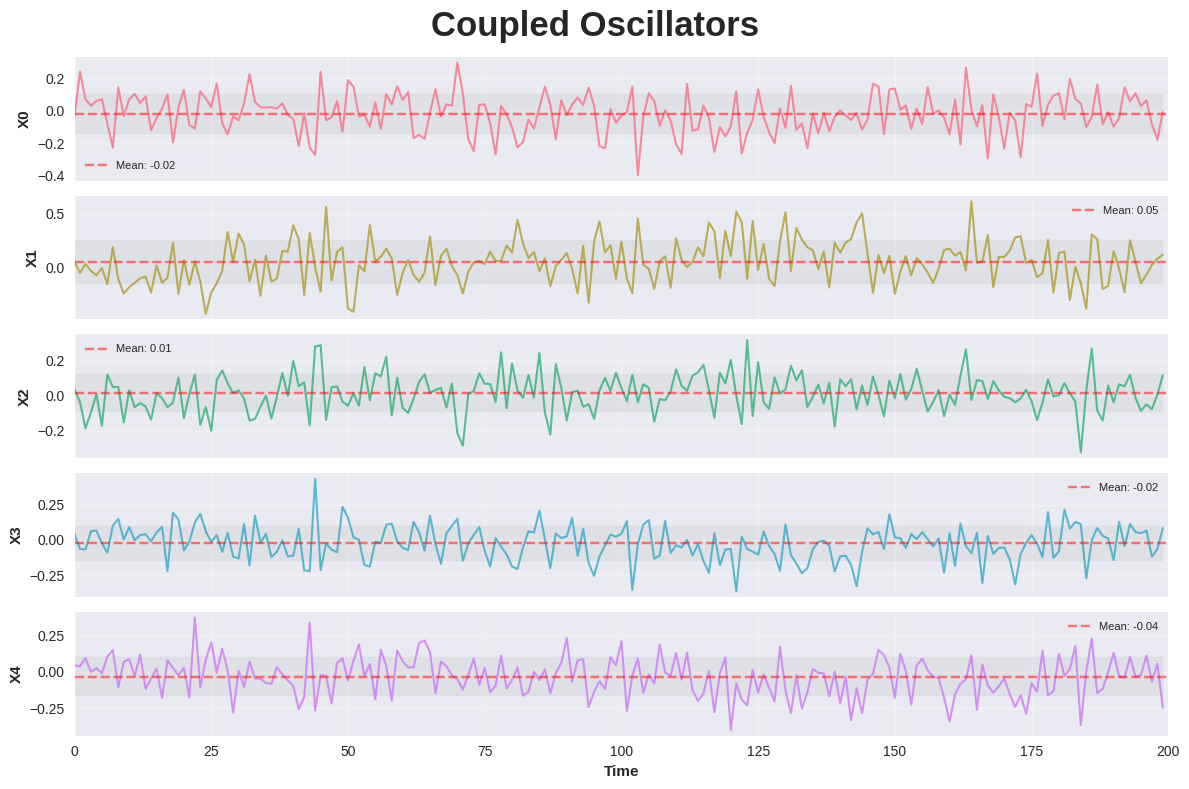

In [16]:
fig, axes = plt.subplots(n_nodes, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Coupled Oscillators', fontsize=25, fontweight='bold')

time = np.arange(T)
colors = sns.color_palette("husl", n_nodes)

for i in range(n_nodes):
    axes[i].plot(time, data[:, i], color=colors[i], alpha=0.8, linewidth=1.5)
    axes[i].set_ylabel(f'X{i}', fontweight='bold')
    axes[i].grid(True, alpha=0.3)

    # Highlight the time series statistics
    mean_val = np.mean(data[:, i])
    std_val = np.std(data[:, i])
    axes[i].axhline(mean_val, color='red', linestyle='--', alpha=0.5, label=f'Mean: {mean_val:.2f}')
    axes[i].fill_between(time, mean_val-std_val, mean_val+std_val, alpha=0.1, color='gray')
    axes[i].legend(fontsize=8)

axes[-1].set_xlabel('Time', fontweight='bold')
axes[-1].set_xlim(0, T)
plt.tight_layout()
plt.show()

# Make into a dataframe!

Our API accepts the input as time series as a numpy array, or a pandas dataframe where the variables are column names.

Nice 😎

In [39]:
import pandas as pd

df = pd.DataFrame(data, columns=["Oscillator One", "Oscillator Two", "Oscillator Three", "Oscillator Four", "Oscillator Five"])
df.head()

,Oscillator One,Oscillator Two,Oscillator Three,Oscillator Four,Oscillator Five
0,-0.035213,0.053231,0.036544,0.041273,0.043082
1,0.240535,-0.056487,-0.036496,-0.063015,0.036530
2,0.072636,0.030669,-0.184619,-0.066878,0.091660
3,0.031596,-0.036137,-0.096931,0.062284,-0.002774
4,0.061663,-0.077599,0.009145,0.066709,0.023776


# Network Discovery

Now let's reconstruct the network from the dataframe.

In [46]:
network = discover_network(
    data=df,
    information='gaussian',
    max_lag=1,
    alpha_forward=0.05,
    alpha_backward=0.05,
    n_shuffles=2000
)


Estimating edges for node 0 (Oscillator One)
Estimating edges for node 1 (Oscillator Two)
Estimating edges for node 2 (Oscillator Three)
Estimating edges for node 3 (Oscillator Four)
Estimating edges for node 4 (Oscillator Five)


# Plot the discoverd network

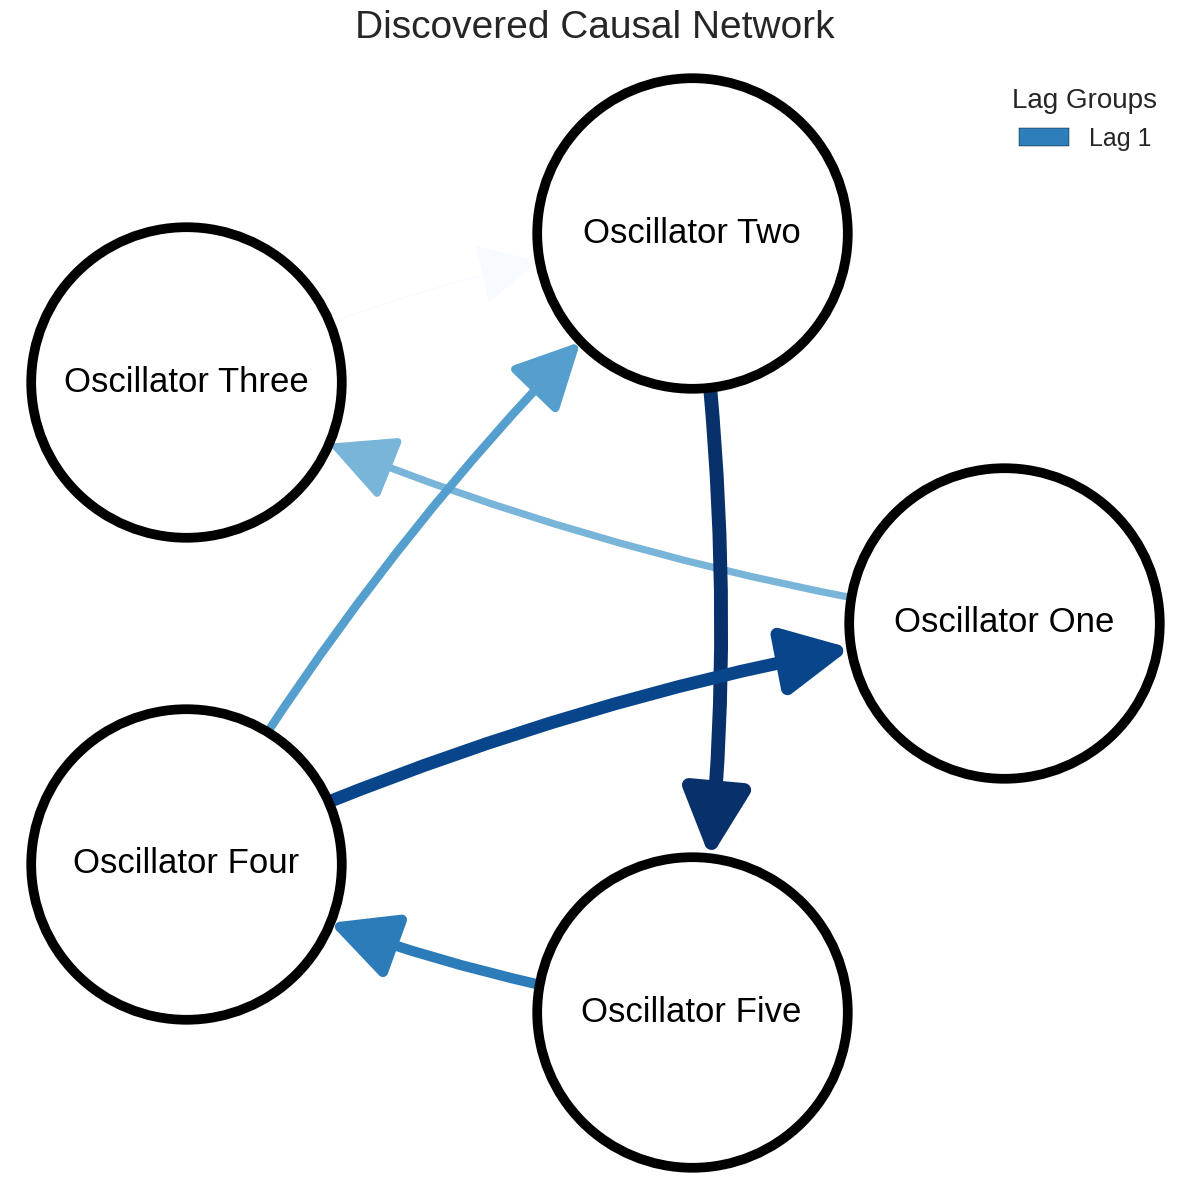

In [47]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from collections import defaultdict
from matplotlib.patches import Patch

# Configuration
CONFIG = {
    'node_size': 50000,
    'arrowsize': 100,
    'label_fontsize': 25,
    'figsize': (12, 12),
    'edge_width_range': (1.0, 10.0),
    'node_linewidth': 7.0,
    'layout': 'circular',
    'colormaps': ['Blues', 'Greens', 'Oranges', 'Purples', 'Reds']
}

# Get layout positions
pos = nx.circular_layout(network)

# Extract edge data
edge_data = defaultdict(list)
for u, v, k, estimated_data in network.edges(keys=True, data=True):
    lag = estimated_data.get('lag', 0)
    cmi = max(0.0, float(estimated_data.get('cmi', 0.0)))
    edge_data[lag].append((u, v, cmi))

# Create plot
fig, ax = plt.subplots(figsize=CONFIG['figsize'])

# Draw nodes
nx.draw_networkx_nodes(
    network, pos,
    node_size=CONFIG['node_size'],
    node_color='white',
    edgecolors='black',
    linewidths=CONFIG['node_linewidth'],
    ax=ax
)

# Draw labels
nx.draw_networkx_labels(network, pos, font_size=CONFIG['label_fontsize'], ax=ax)

# Draw edges by lag
for i, (lag, edges) in enumerate(sorted(edge_data.items())):
    if not edges:
        continue

    # Extract CMI values and normalize
    cmis = np.array([e[2] for e in edges])
    max_cmi = cmis.max() if cmis.max() > 0 else 1.0

    # Calculate edge properties
    widths = CONFIG['edge_width_range'][0] + \
             (CONFIG['edge_width_range'][1] - CONFIG['edge_width_range'][0]) * (cmis / max_cmi)


    colors = plt.cm.get_cmap(CONFIG['colormaps'][i % len(CONFIG['colormaps'])])(cmis / max_cmi)

    # Draw edges for this lag
    nx.draw_networkx_edges(
        network, pos,
        edgelist=[(e[0], e[1]) for e in edges],
        edge_color=colors,
        width=widths,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=CONFIG['arrowsize'],
        connectionstyle=f'arc3,rad={0.15 * (i - len(edge_data)/2)}',
        node_size=CONFIG['node_size'],
        ax=ax
    )

# Create legend (removed duplicate legend code)
legend_elements = []
for i, lag in enumerate(sorted(edge_data.keys())):
    colormap = plt.cm.get_cmap(CONFIG['colormaps'][i % len(CONFIG['colormaps'])])
    color = colormap(0.7)
    legend_elements.append(Patch(facecolor=color, edgecolor='black', label=f'Lag {lag}'))

# Add legend with better positioning
ax.legend(handles=legend_elements, loc='upper right', fontsize=18,
          title='Lag Groups', title_fontsize=20, framealpha=0.9)

# Set axis properties
ax.set_axis_off()
ax.set_title('Discovered Causal Network', fontsize=28, pad=20)

# Adjust margins to ensure everything fits
plt.margins(0.15)  # Add 15% margin around the plot
plt.tight_layout()
plt.show()

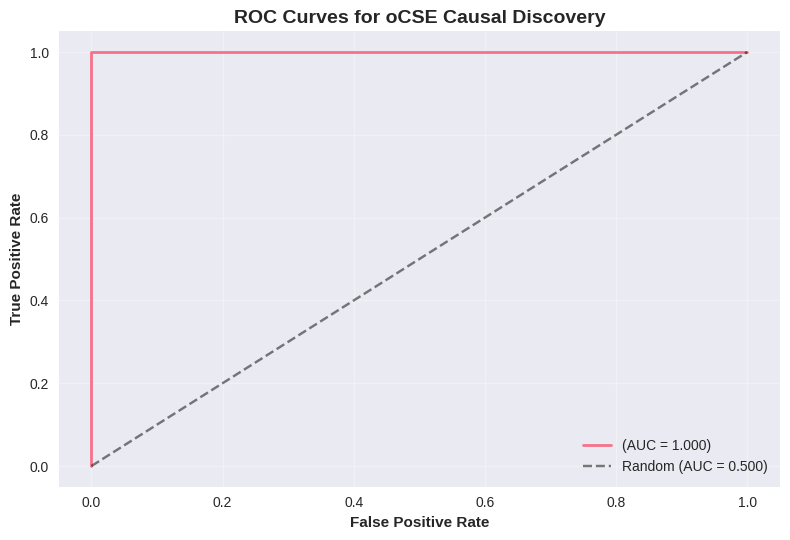

In [59]:
def calculate_roc_auc(true_network, discovered_graph, node_names=None):
    """Calculate ROC-AUC for network discovery performance."""
    true_adj = nx.to_numpy_array(true_network)
    n = true_adj.shape[0]

    discovered_adj = nx.adjacency_matrix(discovered_graph, nodelist=node_names).toarray()

    # Flatten adjacency matrices
    y_true = true_adj.flatten()
    y_scores = discovered_adj.flatten()

    # Remove self-loops (diagonal elements) for fair comparison
    mask = ~np.eye(n, dtype=bool).flatten()
    y_true = y_true[mask]
    y_scores = y_scores[mask]

    auc_score = roc_auc_score(y_true, y_scores)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    return auc_score, fpr, tpr


auc_score, fpr, tpr = calculate_roc_auc(G, network)
plt.plot(fpr, tpr, linewidth=2, label=f'(AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curves for oCSE Causal Discovery', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Comparison to tigramite

In [55]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite.toymodels import surrogate_generator

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.models import Models, Prediction

import math
import sklearn
from sklearn.linear_model import LinearRegression

dataframe = pp.DataFrame(
    data,
    datatime = {0:np.arange(len(data))},
    var_names=["Oscillator One", "Oscillator Two", "Oscillator Three", "Oscillator Four", "Oscillator Five"]
)
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=ParCorr(),
    verbosity=0)
# Note this setup doesn't estimate a multi-graph and there are only directed edges.
results = pcmci.run_pcmci(tau_max=1, pc_alpha=0.01)

In [57]:

def to_networkx(results, binarize=False, p_value=0.05):
    graph = results['graph']
    val_matrix = results['val_matrix']
    p_matrix = results['p_matrix']
    graph = graph.squeeze()

    if graph.ndim == 2:
        # If a non-time series (N,N)-graph is given, insert a dummy dimension
        graph = np.expand_dims(graph, axis = 2)


    N, N, dummy = graph.shape
    tau_max = dummy - 1
    max_lag = tau_max + 1


    # Define graph links by absolute maximum (positive or negative like for
    # partial correlation)
    # val_matrix[np.abs(val_matrix) < sig_thres] = 0.

    # Only draw link in one direction among contemp
    # Remove lower triangle
    link_matrix_upper = np.copy(graph)
    link_matrix_upper[:, :, 0] = np.triu(link_matrix_upper[:, :, 0])

    # net = _get_absmax(link_matrix != "")
    net = np.any(link_matrix_upper != "", axis=2)
    G = nx.DiGraph(net)

    # list of all strengths for color map
    all_strengths = []
    # Add attributes, contemporaneous and lagged links are handled separately
    for (u, v, dic) in G.edges(data=True):
        # average lagfunc for link u --> v ANDOR u -- v

        if u != v:
            for lag in range(max_lag):
                dic[f"egde_type_lag_{lag}"] = link_matrix_upper[u, v, lag]
                dic[f"edge_weight_lag_{lag}"] = val_matrix[u, v, lag]
                if binarize:
                    dic[f"binary_edge_lag_{lag}"] = p_matrix[u, v, lag] < p_value
                    dic[f"binary_edge_lag_{lag}_p_value"] = p_matrix[u, v, lag]
            all_strengths.append(dic[f"edge_weight_lag_{lag}"])
    return G, all_strengths

G_pcmci, _ = to_networkx(results)

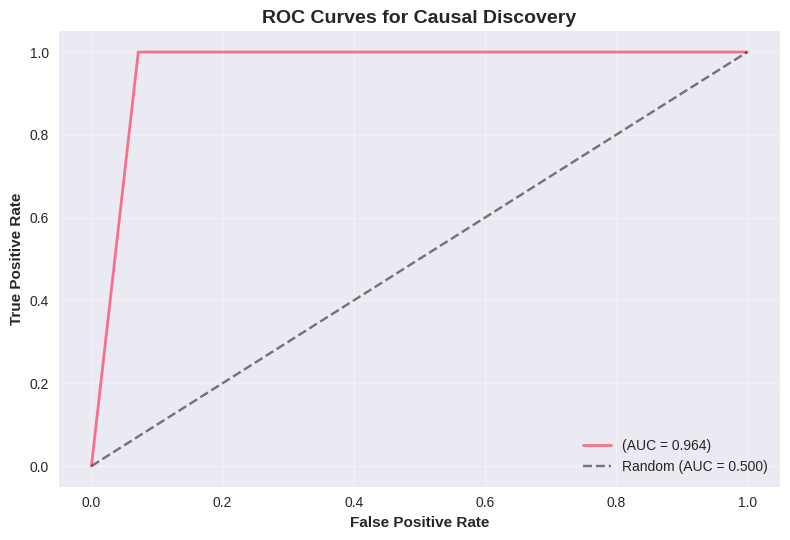

In [58]:
auc_score, fpr, tpr = calculate_roc_auc(G, G_pcmci)
plt.plot(fpr, tpr, linewidth=2, label=f'(AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curves for Causal Discovery', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# A side by side comparison.

Next we will vary the coupling strength and compare the fpr and trp of both optimal causation entropy and pcmci.

In [68]:
from causationentropy.core.stats import Compute_TPR_FPR

# Make an example network for testing.
n_nodes = 5; p = 0.2; seed = 42;
G = nx.erdos_renyi_graph(n_nodes, p, seed=seed, directed=True)
T = 200  # Time series length.
rho = 0.7  # Coupling strength.

# Generate oscillator data. Note that the second return value isn't needed here so we set it to _.
data, _ = linear_stochastic_gaussian_process(
    rho=rho,
    n=n_nodes,
    T=T,
    p=0.2,
    seed=seed,
    G=G
)
network = discover_network(data=data, max_lag=1)
dataframe = pp.DataFrame(data, datatime = {0:np.arange(T)},
    var_names=["X1", "X2", "X3", "X4", "X5"]
)
pcmci = PCMCI(dataframe=dataframe,  cond_ind_test=ParCorr(), verbosity=0)
results = pcmci.run_pcmci(tau_max=1, pc_alpha=0.01)
pcmci_network, _ = to_networkx(results)

A = nx.to_numpy_array(G)
B = nx.to_numpy_array(network)
tpr, fpr = Compute_TPR_FPR(B, A)

C = nx.to_numpy_array(pcmci_network)
tpr, fpr = Compute_TPR_FPR(C, A)

Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)


Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating

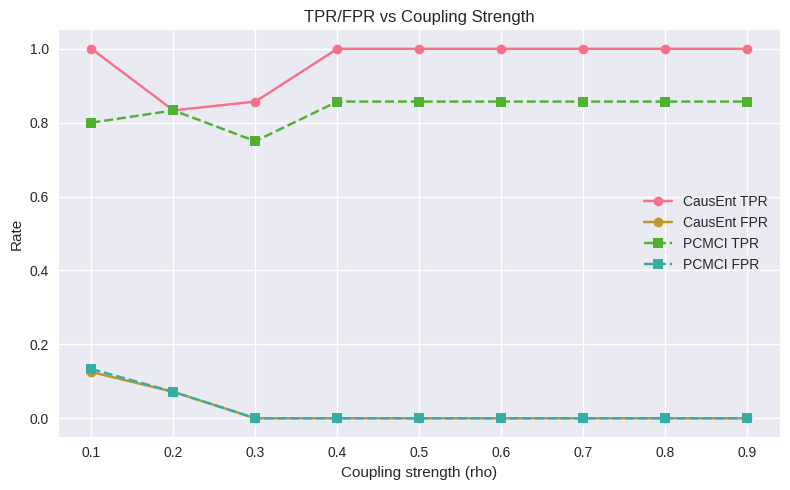

In [69]:
# import numpy as np
# import networkx as nx
# import matplotlib.pyplot as plt

# from causationentropy.core import discover_network
# from causationentropy.core.stats import Compute_TPR_FPR

# import tigramite.data_processing as pp
# from tigramite.pcmci import PCMCI
# from tigramite.independence_tests import ParCorr
# from causationentropy.utils import to_networkx


# --- Setup ---
n_nodes = 5
p = 0.2
seed = 42
T = 200

# Generate a ground-truth graph
G = nx.erdos_renyi_graph(n_nodes, p, seed=seed, directed=True)
A = nx.to_numpy_array(G)

# Sweep over coupling strengths
rhos = np.linspace(0.1, 0.9, 9)   # from low to high coupling
tpr_ce, fpr_ce = [], []
tpr_pcmci, fpr_pcmci = [], []

for rho in rhos:
    # Simulate data
    data, _ = linear_stochastic_gaussian_process(
        rho=rho,
        n=n_nodes,
        T=T,
        p=p,
        seed=seed,
        G=G
    )

    # --- CausationEntropy ---
    network = discover_network(data=data, max_lag=1)
    B = nx.to_numpy_array(network)
    tpr, fpr = Compute_TPR_FPR(B, A)
    tpr_ce.append(tpr)
    fpr_ce.append(fpr)

    # --- PCMCI ---
    dataframe = pp.DataFrame(
        data,
        datatime={0: np.arange(T)},
        var_names=[f"X{i+1}" for i in range(n_nodes)]
    )
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(), verbosity=0)
    results = pcmci.run_pcmci(tau_max=1, pc_alpha=0.01)
    pcmci_network, _ = to_networkx(results)
    C = nx.to_numpy_array(pcmci_network)
    tpr, fpr = Compute_TPR_FPR(C, A)
    tpr_pcmci.append(tpr)
    fpr_pcmci.append(fpr)


# --- Plot ---
plt.figure(figsize=(8, 5))

plt.plot(rhos, tpr_ce, 'o-', label="Optimal Causation Entropy TPR")
plt.plot(rhos, fpr_ce, 'o-', label="Optimal Causation Entropy FPR")

plt.plot(rhos, tpr_pcmci, 's--', label="PCMCI TPR")
plt.plot(rhos, fpr_pcmci, 's--', label="PCMCI FPR")

plt.xlabel("Coupling strength (rho)")
plt.ylabel("Rate")
plt.title("TPR/FPR vs Coupling Strength")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating edges for node 5 (X5)
Estimating edges for node 6 (X6)
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating edges for node 5 (X5)
Estimating edges for node 6 (X6)
Estimating edges for node 7 (X7)
Estimating edges for node 8 (X8)
Estimating edges for node 9 (X9)
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating

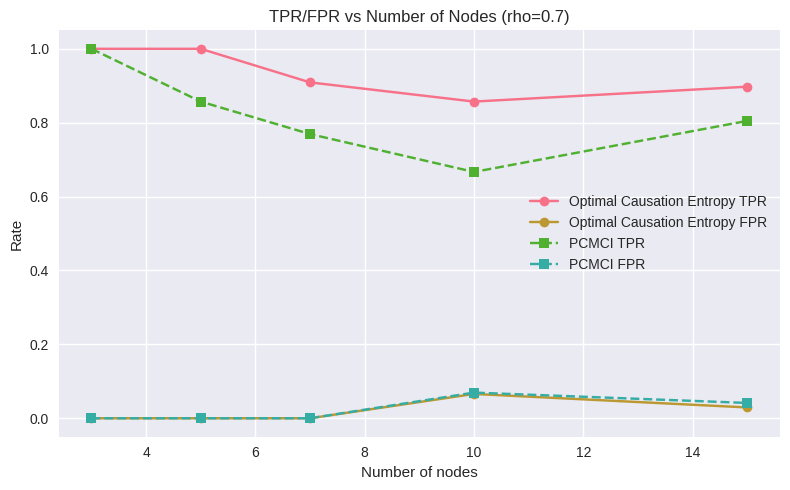

In [74]:
p = 0.2
seed = 42
T = 200
rho = 0.7   # keep coupling strength fixed

# Sweep over number of nodes
node_counts = [3, 5, 7, 10, 15]
tpr_ce, fpr_ce = [], []
tpr_pcmci, fpr_pcmci = [], []

for n_nodes in node_counts:
    # Generate a ground-truth graph for this n
    G = nx.erdos_renyi_graph(n_nodes, p, seed=seed, directed=True)
    A = nx.to_numpy_array(G)

    # Simulate data
    data, _ = linear_stochastic_gaussian_process(
        rho=rho,
        n=n_nodes,
        T=T,
        p=p,
        seed=seed,
        G=G
    )

    # --- CausationEntropy ---
    network = discover_network(data=data, max_lag=1)
    B = nx.to_numpy_array(network)
    tpr, fpr = Compute_TPR_FPR(B, A)
    tpr_ce.append(tpr)
    fpr_ce.append(fpr)

    # --- PCMCI ---
    dataframe = pp.DataFrame(
        data,
        datatime={0: np.arange(T)},
        var_names=[f"X{i+1}" for i in range(n_nodes)]
    )
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(), verbosity=0)
    results = pcmci.run_pcmci(tau_max=1, pc_alpha=0.01)
    pcmci_network, _ = to_networkx(results)
    C = nx.to_numpy_array(pcmci_network)
    tpr, fpr = Compute_TPR_FPR(C, A)
    tpr_pcmci.append(tpr)
    fpr_pcmci.append(fpr)


# --- Plot ---
plt.figure(figsize=(8, 5))

plt.plot(node_counts, tpr_ce, 'o-', label="Optimal Causation Entropy TPR")
plt.plot(node_counts, fpr_ce, 'o-', label="Optimal Causation Entropy FPR")

plt.plot(node_counts, tpr_pcmci, 's--', label="PCMCI TPR")
plt.plot(node_counts, fpr_pcmci, 's--', label="PCMCI FPR")

plt.xlabel("Number of nodes")
plt.ylabel("Rate")
plt.title(f"TPR/FPR vs Number of Nodes (rho={rho})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Varying the edge probability

Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)


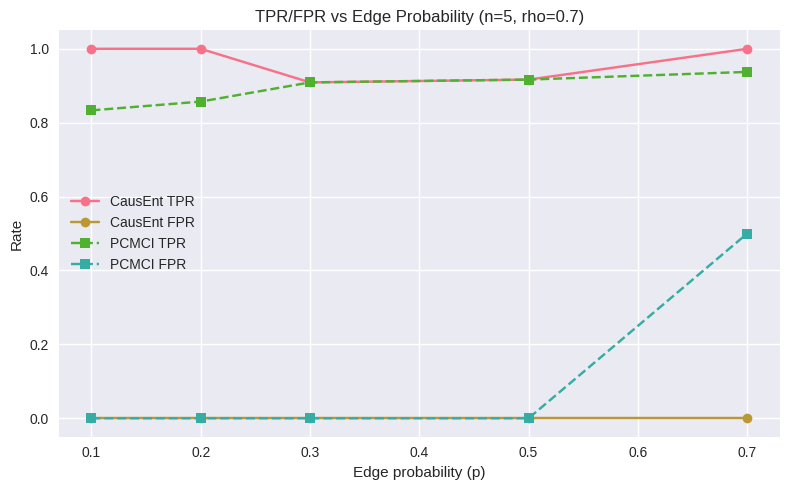

In [73]:
n_nodes = 5
seed = 42
T = 200
rho = 0.7   # fixed coupling

# Sweep over edge probabilities
edge_probs = [0.1, 0.2, 0.3, 0.5, 0.7]
tpr_ce, fpr_ce = [], []
tpr_pcmci, fpr_pcmci = [], []

for p in edge_probs:
    # Generate ground-truth graph
    G = nx.erdos_renyi_graph(n_nodes, p, seed=seed, directed=True)
    A = nx.to_numpy_array(G)

    # Simulate data
    data, _ = linear_stochastic_gaussian_process(
        rho=rho,
        n=n_nodes,
        T=T,
        p=p,
        seed=seed,
        G=G
    )

    # --- CausationEntropy ---
    network = discover_network(data=data, max_lag=1)
    B = nx.to_numpy_array(network)
    tpr, fpr = Compute_TPR_FPR(B, A)
    tpr_ce.append(tpr)
    fpr_ce.append(fpr)

    # --- PCMCI ---
    dataframe = pp.DataFrame(
        data,
        datatime={0: np.arange(T)},
        var_names=[f"X{i+1}" for i in range(n_nodes)]
    )
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(), verbosity=0)
    results = pcmci.run_pcmci(tau_max=1, pc_alpha=0.01)
    pcmci_network, _ = to_networkx(results)
    C = nx.to_numpy_array(pcmci_network)
    tpr, fpr = Compute_TPR_FPR(C, A)
    tpr_pcmci.append(tpr)
    fpr_pcmci.append(fpr)


# --- Plot ---
plt.figure(figsize=(8, 5))

plt.plot(edge_probs, tpr_ce, 'o-', label="Optimal Causation Entropy TPR")
plt.plot(edge_probs, fpr_ce, 'o-', label="Optimal Causation Entropy FPR")

plt.plot(edge_probs, tpr_pcmci, 's--', label="PCMCI TPR")
plt.plot(edge_probs, fpr_pcmci, 's--', label="PCMCI FPR")

plt.xlabel("Edge probability (p)")
plt.ylabel("Rate")
plt.title(f"TPR/FPR vs Edge Probability (n={n_nodes}, rho={rho})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()